In [52]:
# Load model
from tensorflow.keras.models import load_model
import numpy as np

model_path = "../models/ResNet50v2.h5"
model = load_model(model_path)

In [53]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# # Load a sample image (or multiple ones)
IMAGE_PATH = '../raw_data/Testing/meningioma/Te-me_0011.jpg'
img = load_img(IMAGE_PATH, target_size=(255, 255))
img = img_to_array(img)
img = np.expand_dims(img, axis=0)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_8 (Functional)        (None, 8, 8, 2048)        23587712  
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 16)          294928    
                                                                 
 flatten_2 (Flatten)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 50)                51250     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 20)                1020      
                                                                 
 dropout_4 (Dropout)         (None, 20)               

In [42]:
model.predict(img)

1/1 [==============================] - 0s 238ms/step


array([[8.8638999e-04, 9.9816740e-01, 1.2894376e-04, 8.1719615e-04]],
      dtype=float32)

In [54]:
def format_for_expl(img, classification):
    X = img
    y = np.expand_dims(np.array([classification]), axis=0)
    return (X,y)
    

In [55]:
sample = format_for_expl(img, 3)

### Activation visualization

In [22]:
from tf_explain.core.activations import ExtractActivations

ActViz = ExtractActivations()
grid = ActViz.explain(sample, model, layers_name='conv2d_2')
ActViz.save(grid, "../Visualizations/", "ActViz.png")

1/1 [==============================] - 3s 3s/step


### GradCam

In [51]:
from tf_explain.core.grad_cam import GradCAM

#Start explainer
gradcam = GradCAM()
grid = gradcam.explain(sample, model, class_index=1, layer_name='conv2d_2') 

gradcam.save(grid, "../Visualizations/", "grad_cam.png")

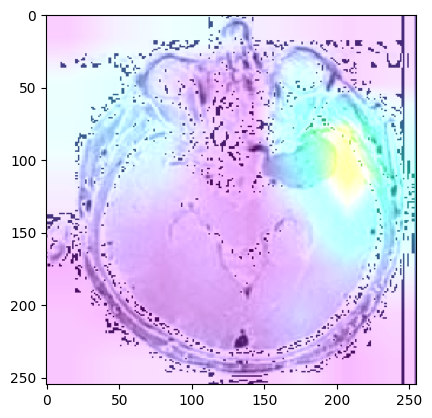

In [52]:
import matplotlib.pyplot as plt

gradcamimage = load_img('../Visualizations/grad_cam.png', target_size=(255, 255))

plt.imshow(gradcamimage)

### VanillaGradients

In [25]:
from tf_explain.core.vanilla_gradients import VanillaGradients

Vanillagrad = VanillaGradients()
grid = Vanillagrad.explain(sample, model, class_index=1) 

Vanillagrad.save(grid, "../Visualizations/", "VanillaGradient.png")

/var/folders/yg/kt4pdk955453dzxyb3ppm5200000gn/T/ipykernel_38857/3700633328.py:4: UserWarning: Unsupported model architecture for VanillaGradients. The last two layers of the model should be: a layer which computes class scores with no activation, followed by an activation layer.
  grid = Vanillagrad.explain(sample, model, class_index=3)


### Occlusion sensitivity map

In [56]:
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

#Start explainer
occsens = OcclusionSensitivity()
grid = occsens.explain(sample, model, class_index=1, patch_size=8) 

occsens.save(grid, "../Visualizations/", "OcclusionSensitivity.png")

 1/32 [..............................] - ETA: 2:30